In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import seaborn

seaborn.set(context="notebook", style="darkgrid")
plt.rcParams["figure.figsize"] = (8, 6)
from tqdm.auto import tqdm, trange

from ssptools import evolve_mf_3 as emf3
from limepy import limepy

import numpy as np
import scipy as sp
import astropy.units as u
import astropy.constants as const

from binaryshift import BinaryShift

In [2]:
m123 = [0.1, 0.5, 1.0, 100]  # Slope breakpoints for initial mass function
a12 = [-0.468, -1.178, -2.117]  # Slopes for initial mass function
nbin12 = [5, 5, 20]

# Output times for the evolution
tout = np.array([11000])

# Integration settings
N0 = 5e5  # Normalization of stars
Ndot = -0.0001  # Regulates how low mass objects are depleted default -20, 0 for 47 Tuc
tcc = 0  # Core collapse time
NS_ret = 0.1  # Initial neutron star retention
BH_ret_int = 1  # Initial Black Hole retention
BH_ret_dyn = 0.00235  # Dynamical Black Hole retention
FeHe = -0.7  # Metallicity

In [3]:
f = emf3.evolve_mf(
    m123=m123,
    a12=a12,
    nbin12=nbin12,
    tout=tout,
    N0=N0,
    Ndot=Ndot,
    tcc=tcc,
    NS_ret=NS_ret,
    BH_ret_int=BH_ret_int,
    BH_ret_dyn=BH_ret_dyn,
    FeHe=FeHe,
    natal_kicks=True,
    vesc=100,
)

/home/peter/research/ssptools/ssptools/evolve_mf_3.py:321: RuntimeWarning: divide by zero encountered in true_divide
  As = Ns / P1
/home/peter/research/ssptools/ssptools/evolve_mf_3.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  Aj = Nj / self.Pk(alphaj, 1, m1, mto)


In [4]:
cs = f.Ns[-1] > 10 * f.Nmin
cr = f.Nr[-1] > 10 * f.Nmin
mj = np.r_[f.ms[-1][cs], f.mr[-1][cr]]
Mj = np.r_[f.Ms[-1][cs], f.Mr[-1][cr]]
dms = f.mes[-1][1:] - f.mes[-1][0:-1]
nms = len(f.ms[-1][cs])

In [5]:
bs = BinaryShift(mj=mj, Mj=Mj, MF=f, verbose=False)

In [6]:
mj_solar, Mj_solar = bs.shift_solar(fb=0.3)
mj_flat, Mj_flat = bs.shift_flat(fb=0.3)

Text(0.5, 0, 'mj [$M_\\odot$]')

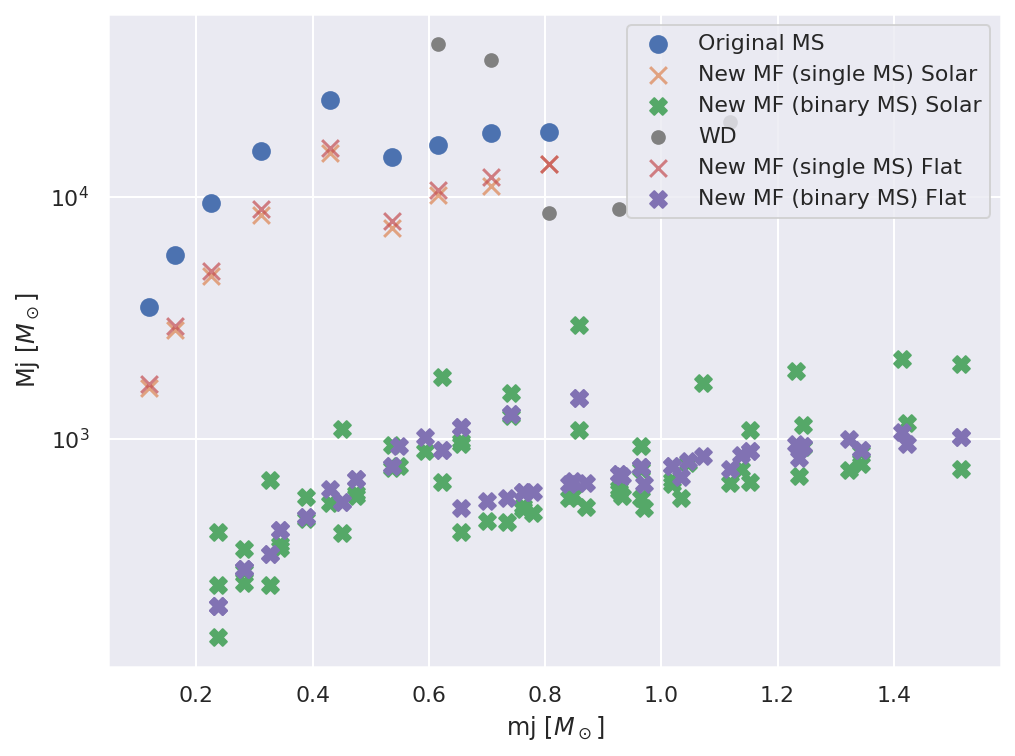

In [7]:
plt.figure()
plt.scatter(mj[bs.MS_mask], Mj[bs.MS_mask], label="Original MS", s=70)

# plt.scatter(mj, Mj, label="Original MF", s=70)

plt.yscale("log")
# plt.ylim(1e2, 1e5)
plt.scatter(
    mj_solar[bs.MS_mask_new],
    Mj_solar[bs.MS_mask_new],
    label="New MF (single MS) Solar",
    marker="x",
    s=70,
    alpha=0.7,
)
plt.scatter(
    mj_solar[bs.bin_mask],
    Mj_solar[bs.bin_mask],
    label="New MF (binary MS) Solar",
    marker="X",
    s=70,
)
plt.scatter(
    mj_solar[bs.WD_mask_new],
    Mj_solar[bs.WD_mask_new],
    label="WD",
    marker="o",
    color="grey",
    s=40,
)


plt.scatter(
    mj_flat[bs.MS_mask_new],
    Mj_flat[bs.MS_mask_new],
    label="New MF (single MS) Flat",
    marker="x",
    s=70,
    alpha=0.7,
)
plt.scatter(
    mj_flat[bs.bin_mask],
    Mj_flat[bs.bin_mask],
    label="New MF (binary MS) Flat",
    marker="X",
    s=70,
)


plt.legend()
plt.ylabel(r"Mj [$M_\odot$]")
plt.xlabel(r"mj [$M_\odot$]")
# plt.savefig("shifted.png",dpi=300)
# plt.xlim(0, 1.7)

In [8]:
l = limepy(
    M=1e6, phi0=6, g=0.8, mj=mj, Mj=Mj, delta=0.45, rh=8, ra=10 ** 1.23, project=True
)

In [9]:
l_solar = limepy(
    M=1e6,
    phi0=6,
    g=0.8,
    mj=mj_solar,
    Mj=Mj_solar,
    delta=0.45,
    rh=8,
    ra=10 ** 1.23,
    project=True,
)

In [10]:
l_flat = limepy(
    M=1e6,
    phi0=6,
    g=0.8,
    mj=mj_flat,
    Mj=Mj_flat,
    delta=0.45,
    rh=8,
    ra=10 ** 1.23,
    project=True,
)

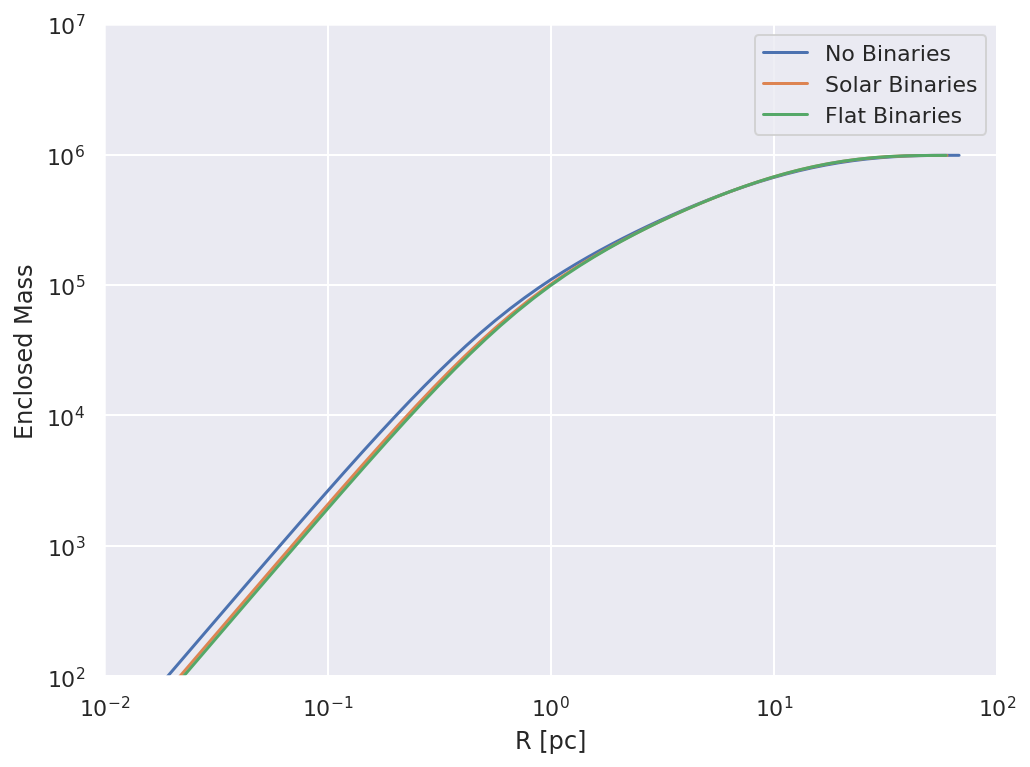

In [11]:
plt.figure()
plt.loglog()
plt.xlim(1e-2, 1e2)
plt.ylim(1e2, 1e7)
plt.plot(l.r, l.mcp, label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel("Enclosed Mass")
plt.plot(l_solar.r, l_solar.mcp, label="Solar Binaries")
plt.plot(l_flat.r, l_flat.mcp, label="Flat Binaries")
plt.legend()

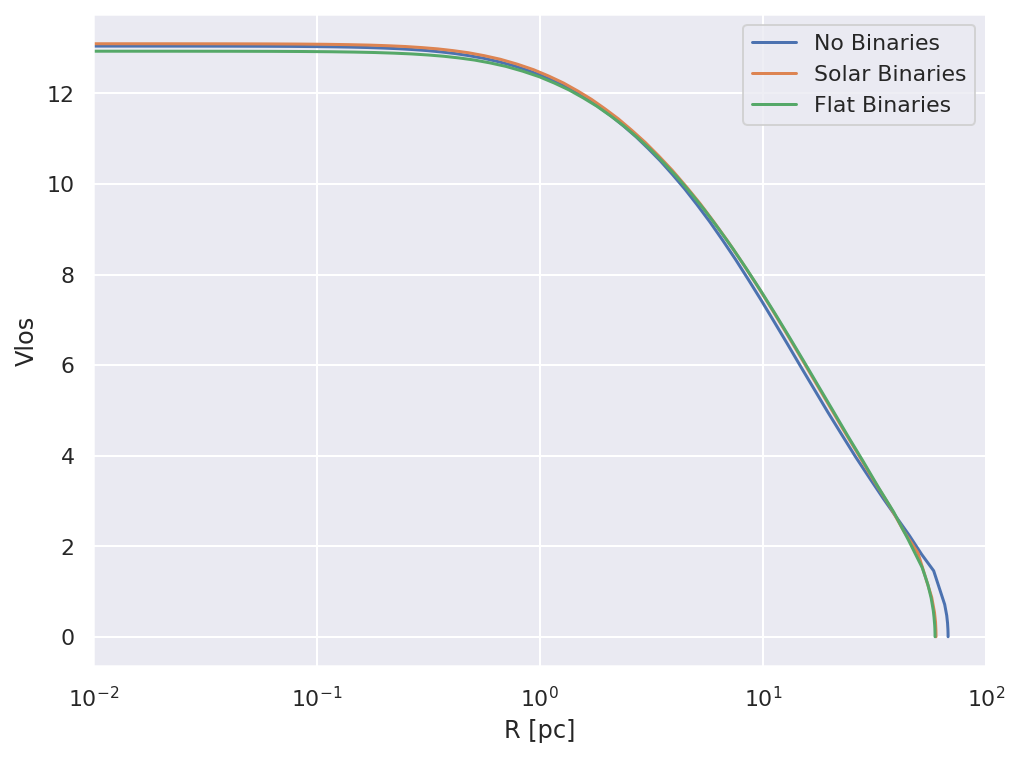

In [12]:
plt.figure()
plt.xscale("log")
plt.xlim(1e-2, 1e2)
plt.plot(l.r, np.sqrt(l.v2pj[9]), label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel("Vlos")
plt.plot(l_solar.r, np.sqrt(l_solar.v2pj[9]), label="Solar Binaries")
plt.plot(l_flat.r, np.sqrt(l_flat.v2pj[9]), label="Flat Binaries")
plt.legend()

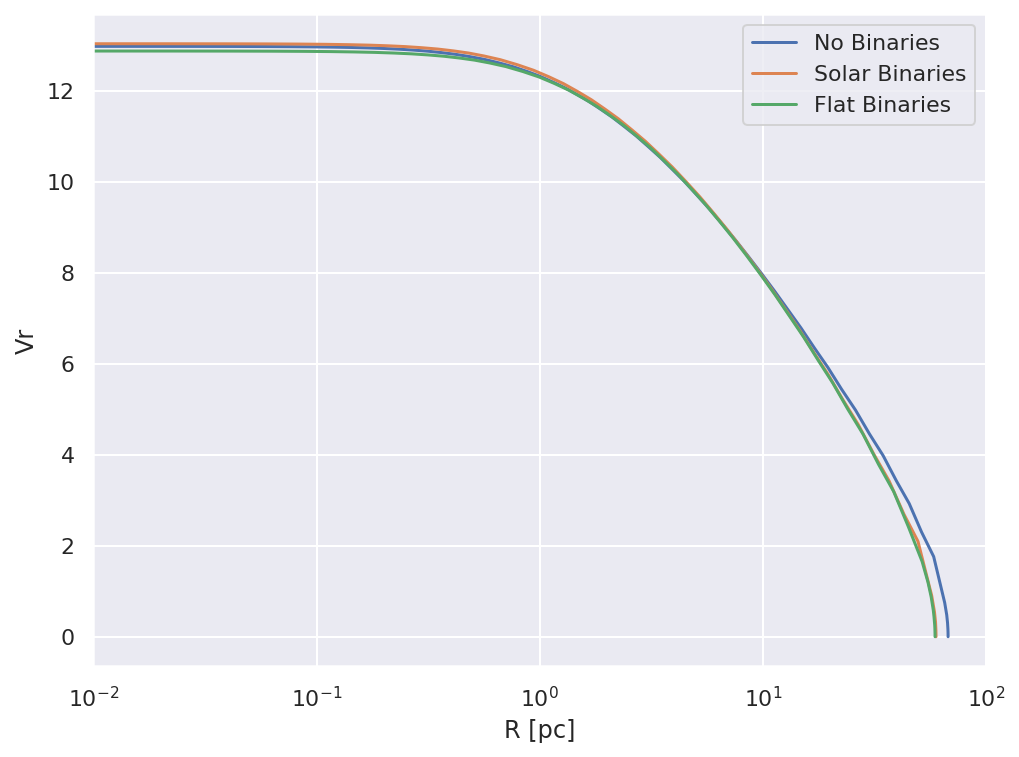

In [13]:
plt.figure()
plt.xscale("log")
plt.xlim(1e-2, 1e2)
plt.plot(l.r, np.sqrt(l.v2Rj[9]), label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel("Vr")
plt.plot(l_solar.r, np.sqrt(l_solar.v2Rj[9]), label="Solar Binaries")
plt.plot(l_flat.r, np.sqrt(l_flat.v2Rj[9]), label="Flat Binaries")

plt.legend()

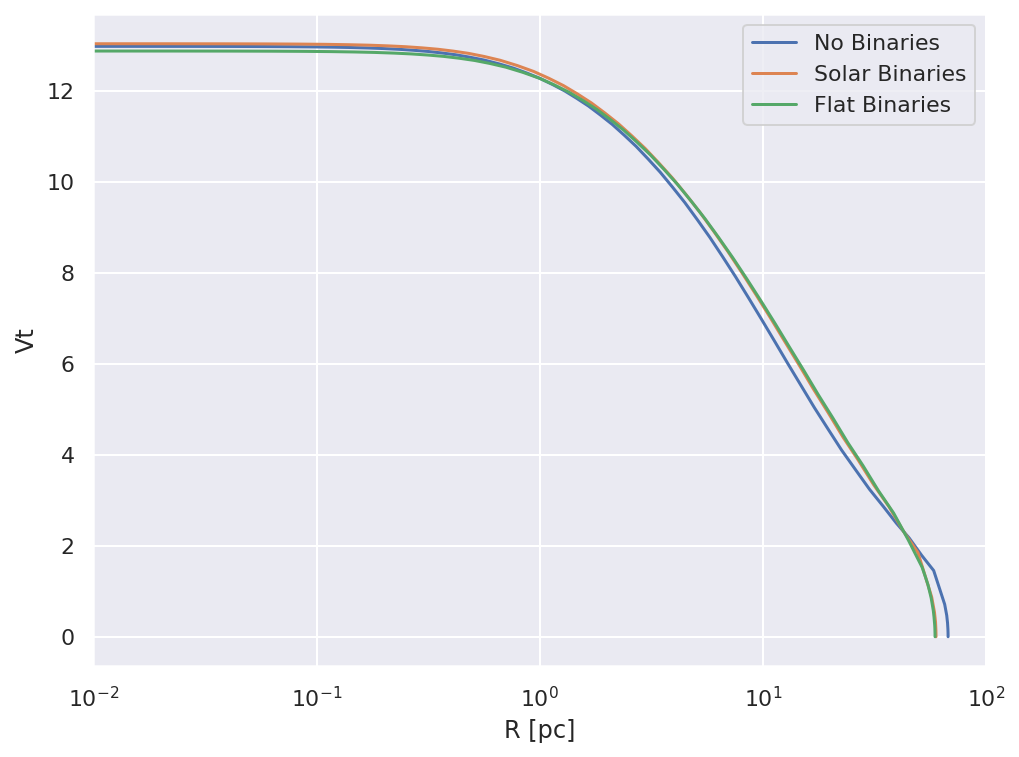

In [14]:
plt.figure()
plt.xscale("log")
plt.xlim(1e-2, 1e2)
plt.plot(l.r, np.sqrt(l.v2Tj[9]), label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel("Vt")
plt.plot(l_solar.r, np.sqrt(l_solar.v2Tj[9]), label="Solar Binaries")
plt.plot(l_flat.r, np.sqrt(l_flat.v2Tj[9]), label="Flat Binaries")
plt.legend()

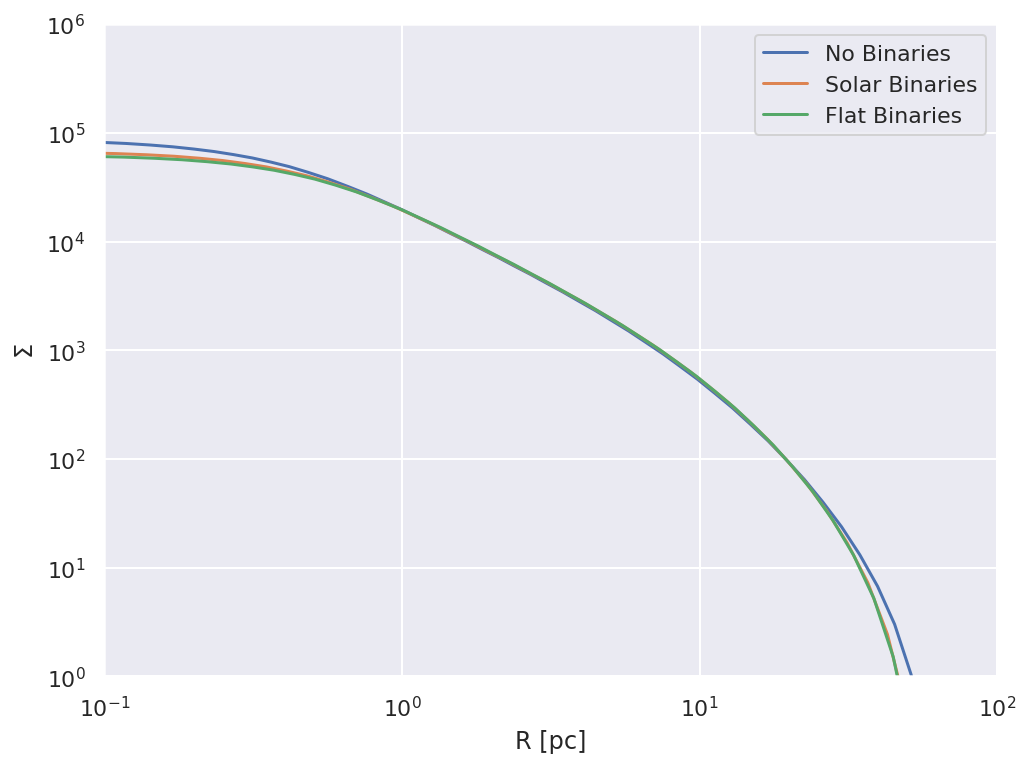

In [15]:
plt.figure()
plt.loglog()
plt.xlim(1e-1, 1e2)
plt.ylim(1e-0, 1e6)
plt.plot(l.r, l.Sigma, label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel(r"$\Sigma$")
plt.plot(l_solar.r, l_solar.Sigma, label="Solar Binaries")
plt.plot(l_flat.r, l_flat.Sigma, label="Flat Binaries")
plt.legend()

In general, it looks like the overall quantities have more seperation between models with/without binaries. 

When we just look at upper MS and Giants, the difference is much much harder to see, almost no difference.

Should have a look at spatial distribution of MS vs Binaries and also at mass function plots